## Data loading

In [2]:
import os
import math
import pickle
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import openmeteo_requests

import mlflow

In [3]:
mlflow.set_experiment("open-meteo-new-york-temperature")

2026/01/29 11:09:13 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2026/01/29 11:09:13 INFO mlflow.store.db.utils: Updating database tables
2026/01/29 11:09:13 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/01/29 11:09:13 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2026/01/29 11:09:13 INFO alembic.runtime.migration: Running upgrade  -> 451aebb31d03, add metric step
2026/01/29 11:09:13 INFO alembic.runtime.migration: Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
2026/01/29 11:09:13 INFO alembic.runtime.migration: Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
2026/01/29 11:09:13 INFO alembic.runtime.migration: Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
2026/01/29 11:09:13 INFO alembic.runtime.migration: Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
2026/01/29 11:09:13 INFO alembic.runtime.migration: Running 

<Experiment: artifact_location='file:a:/All Python Environments/env_04/my_files/OpenMeteo/mlruns/1', creation_time=1769665154639, experiment_id='1', last_update_time=1769665154639, lifecycle_stage='active', name='open-meteo-new-york-temperature', tags={}>

In [4]:
openmeteo = openmeteo_requests.Client()

def get_data(start_date, end_date):
    # Make sure all required weather variables are listed here
    # The order of variables in hourly or daily is important to assign them correctly below
    url = "https://historical-forecast-api.open-meteo.com/v1/forecast"
    params = {
        "latitude": 40.7143,
        "longitude": -74.006,
        "start_date": start_date,
        "end_date": end_date,
        "hourly": [
            "temperature_2m", "apparent_temperature", "snowfall", 
            "relative_humidity_2m", "dew_point_2m", "precipitation_probability", 
            "precipitation", "rain", "showers", "snow_depth", "weather_code", 
            "pressure_msl", "cloud_cover", "cloud_cover_low", "cloud_cover_mid", 
            "cloud_cover_high", "visibility", "temperature_180m", "temperature_120m", 
            "temperature_80m", "wind_gusts_10m", "wind_direction_180m", 
            "vapour_pressure_deficit", "et0_fao_evapotranspiration", 
            "evapotranspiration", "surface_pressure", "wind_direction_120m", 
            "wind_direction_80m", "wind_direction_10m", "wind_speed_180m", 
            "wind_speed_120m", "wind_speed_80m", "wind_speed_10m", 
            "soil_temperature_0cm", "soil_temperature_6cm", "soil_temperature_18cm", 
            "soil_temperature_54cm", "soil_moisture_0_to_1cm", "soil_moisture_1_to_3cm", 
            "soil_moisture_3_to_9cm", "soil_moisture_9_to_27cm", "soil_moisture_27_to_81cm"
        ],
        "timezone": "America/New_York",
    }
    responses = openmeteo.weather_api(url, params=params)

    # Process first location. Add a for-loop for multiple locations or weather models
    response = responses[0]
    print(f"Coordinates: {response.Latitude()}°N {response.Longitude()}°E")
    print(f"Elevation: {response.Elevation()} m asl")
    print(f"Timezone: {response.Timezone()}{response.TimezoneAbbreviation()}")
    print(f"Timezone difference to GMT+0: {response.UtcOffsetSeconds()}s")

    # Process hourly data. The order of variables needs to be the same as requested.
    hourly = response.Hourly()
    feature_values = []
    for i in range(42):
        feature_values.append(hourly.Variables(i).ValuesAsNumpy())

    feature_names = [
        "temperature_2m", "apparent_temperature", "snowfall",
        "relative_humidity_2m", "dew_point_2m", "precipitation_probability",
        "precipitation", "rain", "showers", "snow_depth", "weather_code",
        "pressure_msl", "cloud_cover", "cloud_cover_low", "cloud_cover_mid",
        "cloud_cover_high", "visibility", "temperature_180m",
        "temperature_120m", "temperature_80m", "wind_gusts_10m",
        "wind_direction_180m", "vapour_pressure_deficit",
        "et0_fao_evapotranspiration", "evapotranspiration", "surface_pressure",
        "wind_direction_120m", "wind_direction_80m", "wind_direction_10m",
        "wind_speed_180m", "wind_speed_120m", "wind_speed_80m",
        "wind_speed_10m", "soil_temperature_0cm", "soil_temperature_6cm",
        "soil_temperature_18cm", "soil_temperature_54cm",
        "soil_moisture_0_to_1cm", "soil_moisture_1_to_3cm",
        "soil_moisture_3_to_9cm", "soil_moisture_9_to_27cm",
        "soil_moisture_27_to_81cm"
    ]

    hourly_data = {"date": pd.date_range(
        start = pd.to_datetime(hourly.Time() + response.UtcOffsetSeconds(), unit = "s", utc = True),
        end =  pd.to_datetime(hourly.TimeEnd() + response.UtcOffsetSeconds(), unit = "s", utc = True),
        freq = pd.Timedelta(seconds = hourly.Interval()),
        inclusive = "left"
    )}

    for feature_name, feature_value in zip(feature_names, feature_values):
        hourly_data[feature_name] = feature_value

    return pd.DataFrame(data = hourly_data)


In [5]:
start_date = "2023-01-01"
end_date = "2023-12-31"

df = get_data(start_date, end_date)


Coordinates: 40.71033477783203°N -73.99308013916016°E
Elevation: 51.0 m asl
Timezone: b'America/New_York'b'GMT-5'
Timezone difference to GMT+0: -18000s


In [6]:
file_path = f"./data/{start_date}_{end_date}.csv"

if not os.path.exists(file_path):
    df.to_csv(file_path)
else:
    print(f"{file_path} already exists")
    

./data/2023-01-01_2023-12-31.csv already exists


## Sanity Check

In [7]:
df.shape

(8760, 43)

In [8]:
df.head()

date  temperature_2m  apparent_temperature  snowfall  \
0 2023-01-01 00:00:00+00:00       11.107500             10.211172       0.0   
1 2023-01-01 01:00:00+00:00       11.057501              9.372974       0.0   
2 2023-01-01 02:00:00+00:00       10.807501              8.927717       0.0   
3 2023-01-01 03:00:00+00:00       10.207500              8.373623       0.0   
4 2023-01-01 04:00:00+00:00       10.107500              8.192934       0.0   

   relative_humidity_2m  dew_point_2m  precipitation_probability  \
0                  94.0     10.177910                        NaN   
1                  95.0     10.286714                        NaN   
2                  94.0      9.880099                        NaN   
3                  93.0      9.125606                        NaN   
4                  91.0      8.704404                        NaN   

   precipitation  rain  showers  ...  wind_speed_10m  soil_temperature_0cm  \
0            0.0   0.0      0.0  ...        6.608722                7.9465   
1            0.0   0.0      0.0  ...       12.229406                7.9465   
2            0.0   0.0      0.0  ...       12.768586                7.8465   
3            0.0   0.0      0.0  ...       11.019764                7.7965   
4            0.0   0.0      0.0  ...       10.799999                7.4465   

   soil_temperature_6cm  soil_temperature_18cm  soil_temperature_54cm  \
0                8.3965                 6.8965                 4.8465   
1                8.3965                 6.9465                 4.8965   
2                8.2965                 6.9965                 4.9465   
3                8.2465                 7.0465                 4.9965   
4                8.1465                 7.0965                 4.9965   

   soil_moisture_0_to_1cm  soil_moisture_1_to_3cm  soil_moisture_3_to_9cm  \
0                   0.347                   0.349                   0.353   
1                   0.345                   0.347                   0.351   
2                   0.340                   0.342                   0.346   
3                   0.337                   0.339                   0.343   
4                   0.334                   0.336                   0.340   

   soil_moisture_9_to_27cm  soil_moisture_27_to_81cm  
0                    0.334                      0.34  
1                    0.338                      0.34  
2                    0.340                      0.34  
3                    0.341                      0.34  
4                    0.341                      0.34  

[5 rows x 43 columns]

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 43 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   date                        8760 non-null   datetime64[ns, UTC]
 1   temperature_2m              8760 non-null   float32            
 2   apparent_temperature        8760 non-null   float32            
 3   snowfall                    8760 non-null   float32            
 4   relative_humidity_2m        8760 non-null   float32            
 5   dew_point_2m                8760 non-null   float32            
 6   precipitation_probability   0 non-null      float32            
 7   precipitation               8760 non-null   float32            
 8   rain                        8760 non-null   float32            
 9   showers                     8760 non-null   float32            
 10  snow_depth                  8760 non-null   float32         

In [10]:
df.describe().T

count          mean           std         min  \
temperature_2m              8760.0     13.664881      8.797551  -15.892500   
apparent_temperature        8760.0     11.918356     11.181728  -22.974426   
snowfall                    8760.0      0.001422      0.034973    0.000000   
relative_humidity_2m        8760.0     65.143494     20.046135   13.000000   
dew_point_2m                8760.0      6.506922      9.525837  -25.923918   
precipitation_probability      0.0           NaN           NaN         NaN   
precipitation               8760.0      0.132215      1.735762    0.000000   
rain                        8760.0      0.130183      1.734197    0.000000   
showers                     8760.0      0.000000      0.000000    0.000000   
snow_depth                  8760.0      0.000244      0.003727    0.000000   
weather_code                8760.0      4.976941     14.085014    0.000000   
pressure_msl                8760.0   1015.590759      7.932999  982.799988   
cloud_cover                 8760.0     48.124088     44.148499    0.000000   
cloud_cover_low             8760.0     35.986301     43.035686    0.000000   
cloud_cover_mid             8760.0     21.952055     38.099087    0.000000   
cloud_cover_high            8760.0     17.670092     34.036808    0.000000   
visibility                  8760.0  29522.156250  15584.675781  100.000000   
temperature_180m            8760.0     11.936854      8.385131  -18.253500   
temperature_120m            8760.0     13.090569      8.536748  -16.671001   
temperature_80m             8760.0     13.253583      8.536613  -16.421001   
wind_gusts_10m              8760.0     22.002287     12.349529    0.720000   
wind_direction_180m         8760.0    211.030365    102.416664    0.395131   
vapour_pressure_deficit     8760.0      0.642822      0.602474    0.000000   
et0_fao_evapotranspiration  8760.0      0.125146      0.165359    0.000000   
evapotranspiration          8760.0      0.000196      0.002144    0.000000   
surface_pressure            8760.0   1009.437439      7.832356  976.863525   
wind_direction_120m         8760.0    210.272034    104.157700    0.567252   
wind_direction_80m          8760.0    204.309326    103.204857    0.784807   
wind_direction_10m          8760.0    201.435440    102.860809    0.970998   
wind_speed_180m             8760.0     25.529276     12.727988    0.509117   
wind_speed_120m             8760.0     22.039705     10.724013    0.519648   
wind_speed_80m              8760.0     18.546700      9.543877    0.000000   
wind_speed_10m              8760.0     11.271240      6.576693    0.360000   
soil_temperature_0cm        8760.0     14.509102      8.840791   -9.553500   
soil_temperature_6cm        8760.0     14.701676      8.860497   -9.153500   
soil_temperature_18cm       8760.0     14.676968      7.862956   -0.303500   
soil_temperature_54cm       8760.0     14.565728      6.630210    3.846500   
soil_moisture_0_to_1cm      8760.0      0.304592      0.029777    0.203000   
soil_moisture_1_to_3cm      8760.0      0.306175      0.028806    0.216000   
soil_moisture_3_to_9cm      8760.0      0.309754      0.026838    0.236000   
soil_moisture_9_to_27cm     8760.0      0.319037      0.022492    0.263000   
soil_moisture_27_to_81cm    8760.0      0.338938      0.015506    0.301000   

                                     25%           50%           75%  \
temperature_2m                  6.507500     13.107500     21.157501   
apparent_temperature            2.695229     10.773846     21.309946   
snowfall                        0.000000      0.000000      0.000000   
relative_humidity_2m           49.000000     65.000000     83.000000   
dew_point_2m                   -1.005532      6.858153     13.993522   
precipitation_probability            NaN           NaN           NaN   
precipitation                   0.000000      0.000000      0.000000   
rain                            0.000000      0.000000      0.000000   
showers                   

In [11]:
df["month"] = df.date.dt.month

In [12]:
df = df.fillna(0)

## Analysis

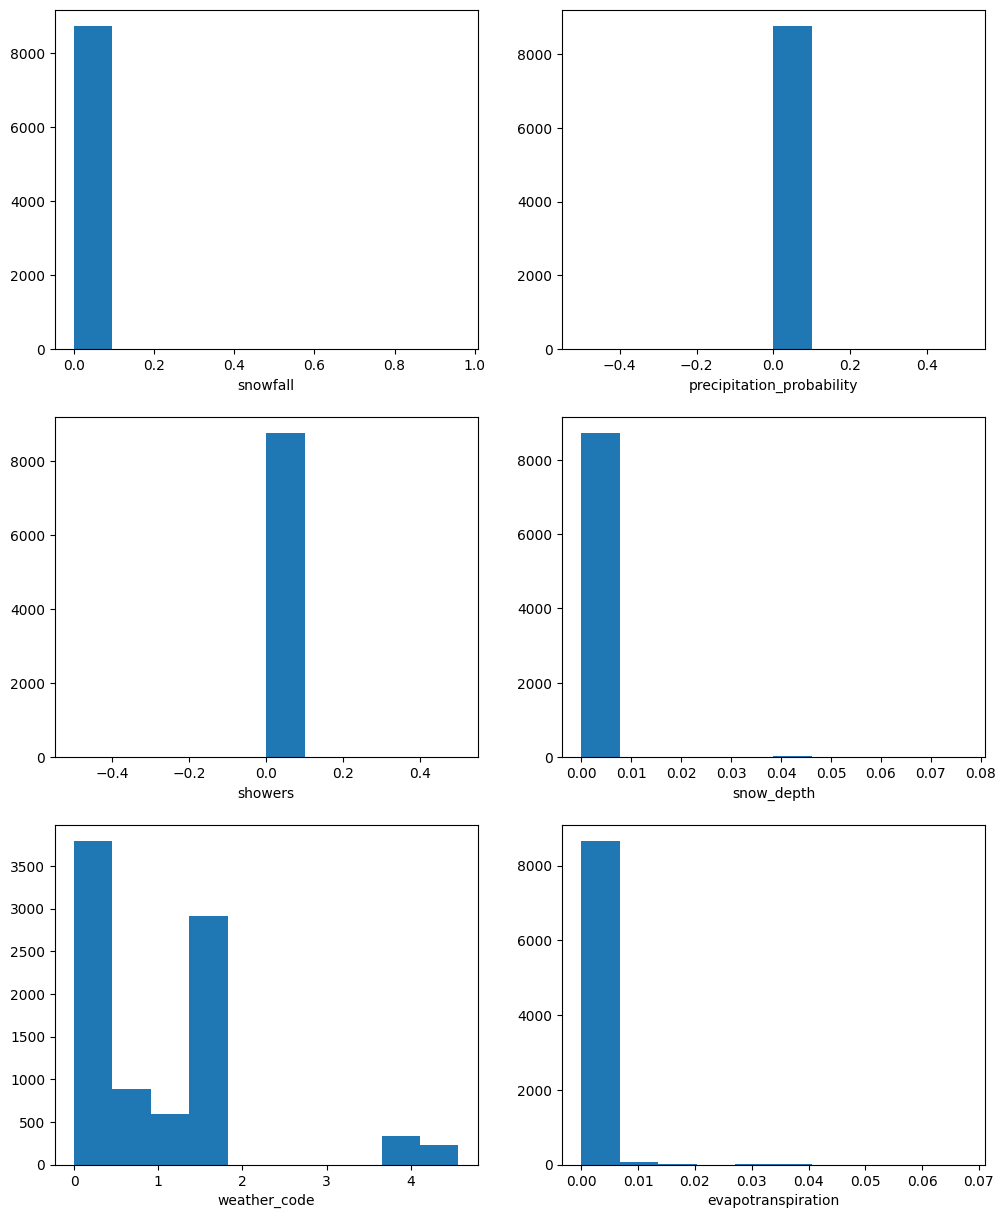

In [13]:
plot_cols = []
for col in df.columns:
    if df[col].nunique() > 0 and df[col].nunique() < 20:
        plot_cols.append(col)
plot_cols.remove("month")

num_rows = math.ceil(len(plot_cols) / 2)
fig, axs = plt.subplots(nrows=num_rows, ncols=2, figsize=(12, 5 * num_rows))

k = 0
for i in range(len(axs)):
    for j in range(len(axs[i])):
        if k >= len(plot_cols): break
        axs[i, j].hist(df[plot_cols[k]].apply(np.log1p))
        axs[i, j].set_xlabel(plot_cols[k])
        axs[i, j].set
        k = k + 1


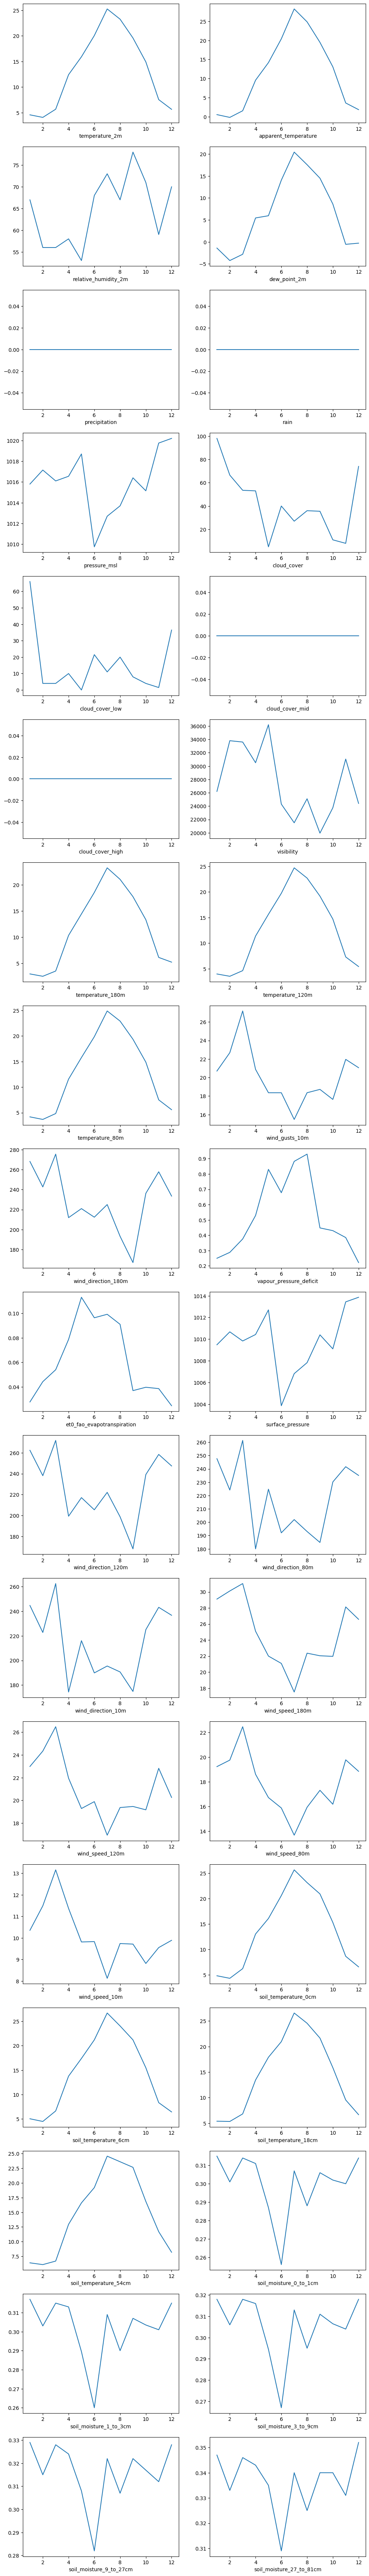

In [14]:
plot_cols = []
for col in df.columns:
    if df[col].nunique() >= 20:
        plot_cols.append(col)
plot_cols.remove("date")

num_rows = math.ceil(len(plot_cols) / 2)
fig, axs = plt.subplots(nrows=num_rows, ncols=2, figsize=(12, 5 * num_rows))

k = 0
for i in range(len(axs)):
    for j in range(len(axs[i])):
        if k >= len(plot_cols): break
        axs[i, j].plot(df["month"].unique(), df.groupby("month").median()[plot_cols[k]])
        axs[i, j].set_xlabel(plot_cols[k])
        axs[i, j].set
        k = k + 1


## Machine Learning

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import Input # type: ignore
from tensorflow.keras.layers import Dense # type: ignore
from tensorflow.keras.layers import Dropout # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore

a:\All Python Environments\env_04\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [16]:
# selecting meaningful columns for prediction
selected_columns = [
    "dew_point_2m",
    "pressure_msl",
    "surface_pressure",
    "cloud_cover",
    "cloud_cover_low",
    "cloud_cover_mid",
    "cloud_cover_high",
    "visibility",
    "weather_code",
    "precipitation_probability",
    "precipitation",
    "rain",
    "showers",
    "snowfall",
    "wind_speed_10m",
    "wind_gusts_10m",
    "wind_direction_10m",
    "vapour_pressure_deficit",
    "et0_fao_evapotranspiration",
    "evapotranspiration"
]

X = df[selected_columns]
y = df["temperature_2m"]

In [17]:
numerical_cols = []
categorical_cols = []
target_col = "temperature_2m"
for col in X.columns:
    if X[col].nunique() > 1 and X[col].nunique() <= 10:
        categorical_cols.append(col)
    elif X[col].nunique() > 10:
        numerical_cols.append(col)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7008, 20), (1752, 20), (7008,), (1752,))

In [20]:
with mlflow.start_run(run_name="linear_regression"):
    
    mlflow.set_tags({
        "model": "Linear Regression",
        "project": "open-meteo-new-york-temperature",
    })
    
    mlflow.log_params({
        "train_samples": X_train.shape[0],
        "test_samples": X_test.shape[0],
        "num_features": X_train.shape[1]
    })
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    lr = LinearRegression()
    lr.fit(X_train_scaled, y_train)

    y_pred = lr.predict(X_train_scaled)

    mae = mean_absolute_error(y_train, y_pred)
    rmse = root_mean_squared_error(y_train, y_pred)
    r2 = r2_score(y_train, y_pred)

    mlflow.log_metrics({
        "train_mae": mae,
        "train_rmse": rmse,
        "train_r2_score": r2,
    })

    print("Train metrics:")
    print("MSE:",mae)
    print("RMSE:",rmse)
    print("R2:",r2)

    # ----------------------------------------------
    X_test_scaled = scaler.transform(X_test)

    y_pred = lr.predict(X_test_scaled)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    mlflow.log_metrics({
        "test_mae": mae,
        "test_rmse": rmse,
        "test_r2_score": r2,
    })

    print("Test metrics:")
    print("MSE:",mean_absolute_error(y_test, y_pred))
    print("RMSE:",root_mean_squared_error(y_test, y_pred))
    print("R2:",r2_score(y_test, y_pred))

Train metrics:
MSE: 0.3664412796497345
RMSE: 0.5766584873199463
R2: 0.9956983327865601
Test metrics:
MSE: 0.3722054064273834
RMSE: 0.5435929298400879
R2: 0.9961969256401062


In [21]:
with mlflow.start_run(run_name="lasso_regression"):

    mlflow.set_tags({
        "model": "Lasso Regression",
        "project": "open-meteo-new-york-temperature",
    })
    
    mlflow.log_params({
        "train_samples": X_train.shape[0],
        "test_samples": X_test.shape[0],
        "num_features": X_train.shape[1]
    })
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    lasso = Lasso()
    lasso.fit(X_train_scaled, y_train)

    y_pred = lasso.predict(X_train_scaled)

    mae = mean_absolute_error(y_train, y_pred)
    rmse = root_mean_squared_error(y_train, y_pred)
    r2 = r2_score(y_train, y_pred)

    mlflow.log_metrics({
        "train_mae": mae,
        "train_rmse": rmse,
        "train_r2_score": r2,
    })

    print("Train metrics:")
    print("MSE:",mae)
    print("RMSE:",rmse)
    print("R2:",r2)

    # ----------------------------------------------
    X_test_scaled = scaler.transform(X_test)

    y_pred = lasso.predict(X_test_scaled)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    mlflow.log_metrics({
        "test_mae": mae,
        "test_rmse": rmse,
        "test_r2_score": r2,
    })

    print("Test metrics:")
    print("MSE:",mae)
    print("RMSE:",rmse)
    print("R2:",r2)

Train metrics:
MSE: 1.7666758298873901
RMSE: 2.1240921020507812
R2: 0.9416361451148987
Test metrics:
MSE: 1.7552047967910767
RMSE: 2.133378505706787
R2: 0.9414231777191162


In [22]:
with mlflow.start_run(run_name="ridge_regression"):

    mlflow.set_tags({
        "model": "Ridge Regression",
        "project": "open-meteo-new-york-temperature",
    })
    
    mlflow.log_params({
        "train_samples": X_train.shape[0],
        "test_samples": X_test.shape[0],
        "num_features": X_train.shape[1]
    })
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    ridge = Ridge()
    ridge.fit(X_train_scaled, y_train)

    y_pred = ridge.predict(X_train_scaled)

    mae = mean_absolute_error(y_train, y_pred)
    rmse = root_mean_squared_error(y_train, y_pred)
    r2 = r2_score(y_train, y_pred)

    mlflow.log_metrics({
        "train_mae": mae,
        "train_rmse": rmse,
        "train_r2_score": r2,
    })

    print("Train metrics:")
    print("MSE:",mae)
    print("RMSE:",rmse)
    print("R2:",r2)

    # ----------------------------------------------
    X_test_scaled = scaler.transform(X_test)

    y_pred = ridge.predict(X_test_scaled)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    mlflow.log_metrics({
        "test_mae": mae,
        "test_rmse": rmse,
        "test_r2_score": r2,
    })

    print("Test metrics:")
    print("MSE:",mae)
    print("RMSE:",rmse)
    print("R2:",r2)

Train metrics:
MSE: 0.3626416325569153
RMSE: 0.5699339509010315
R2: 0.9957981109619141
Test metrics:
MSE: 0.3682800233364105
RMSE: 0.5373873710632324
R2: 0.996283233165741


In [23]:
with mlflow.start_run(run_name="elastic_net_regression"):

    mlflow.set_tags({
        "model": "Elastic Net Regression",
        "project": "open-meteo-new-york-temperature",
    })
    
    mlflow.log_params({
        "train_samples": X_train.shape[0],
        "test_samples": X_test.shape[0],
        "num_features": X_train.shape[1]
    })

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    elastic = ElasticNet()
    elastic.fit(X_train_scaled, y_train)

    y_pred = elastic.predict(X_train_scaled)

    mae = mean_absolute_error(y_train, y_pred)
    rmse = root_mean_squared_error(y_train, y_pred)
    r2 = r2_score(y_train, y_pred)

    mlflow.log_metrics({
        "train_mae": mae,
        "train_rmse": rmse,
        "train_r2_score": r2,
    })

    print("Train metrics:")
    print("MSE:",mae)
    print("RMSE:",rmse)
    print("R2:",r2)

    # ----------------------------------------------
    X_test_scaled = scaler.transform(X_test)

    y_pred = elastic.predict(X_test_scaled)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    mlflow.log_metrics({
        "test_mae": mae,
        "test_rmse": rmse,
        "test_r2_score": r2,
    })

    print("Test metrics:")
    print("MSE:",mae)
    print("RMSE:",rmse)
    print("R2:",r2)

Train metrics:
MSE: 2.836834669113159
RMSE: 3.3264150619506836
R2: 0.8568636178970337
Test metrics:
MSE: 2.804776191711426
RMSE: 3.295217275619507
R2: 0.8602479696273804


In [24]:
with mlflow.start_run(run_name="decision_tree_regression"):

    mlflow.set_tags({
        "model": "Decision Tree Regression",
        "project": "open-meteo-new-york-temperature",
    })
    
    mlflow.log_params({
        "train_samples": X_train.shape[0],
        "test_samples": X_test.shape[0],
        "num_features": X_train.shape[1]
    })

    dt = DecisionTreeRegressor()
    dt.fit(X_train, y_train)

    y_pred = dt.predict(X_train)

    mae = mean_absolute_error(y_train, y_pred)
    rmse = root_mean_squared_error(y_train, y_pred)
    r2 = r2_score(y_train, y_pred)

    mlflow.log_metrics({
        "train_mae": mae,
        "train_rmse": rmse,
        "train_r2_score": r2,
    })

    print("Train metrics:")
    print("MSE:",mae)
    print("RMSE:",rmse)
    print("R2:",r2)

    # ----------------------------------------------
    y_pred = dt.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    mlflow.log_metrics({
        "test_mae": mae,
        "test_rmse": rmse,
        "test_r2_score": r2,
    })

    print("Test metrics:")
    print("MSE:",mae)
    print("RMSE:",rmse)
    print("R2:",r2)

Train metrics:
MSE: 0.0
RMSE: 0.0
R2: 1.0
Test metrics:
MSE: 0.2613013794382005
RMSE: 0.37709083350320194
R2: 0.9981698698366683


In [25]:
with mlflow.start_run(run_name="random_forest_regression"):

    mlflow.set_tags({
        "model": "Random Forest Regression",
        "project": "open-meteo-new-york-temperature",
    })
    
    mlflow.log_params({
        "train_samples": X_train.shape[0],
        "test_samples": X_test.shape[0],
        "num_features": X_train.shape[1]
    })

    rf = RandomForestRegressor()
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_train)

    mae = mean_absolute_error(y_train, y_pred)
    rmse = root_mean_squared_error(y_train, y_pred)
    r2 = r2_score(y_train, y_pred)

    mlflow.log_metrics({
        "train_mae": mae,
        "train_rmse": rmse,
        "train_r2_score": r2,
    })

    print("Train metrics:")
    print("MSE:",mae)
    print("RMSE:",rmse)
    print("R2:",r2)

    # ----------------------------------------------
    y_pred = rf.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    mlflow.log_metrics({
        "test_mae": mae,
        "test_rmse": rmse,
        "test_r2_score": r2,
    })

    print("Test metrics:")
    print("MSE:",mae)
    print("RMSE:",rmse)
    print("R2:",r2)

Train metrics:
MSE: 0.04223501538449568
RMSE: 0.06960481516264919
R2: 0.9999373276851715
Test metrics:
MSE: 0.11215183165502739
RMSE: 0.19357176582403535
R2: 0.9995177479842565


In [26]:
with mlflow.start_run(run_name="support_vector_regression"):

    mlflow.set_tags({
        "model": "Support Vector Regression",
        "project": "open-meteo-new-york-temperature",
    })
    
    mlflow.log_params({
        "train_samples": X_train.shape[0],
        "test_samples": X_test.shape[0],
        "num_features": X_train.shape[1]
    })

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    svr = SVR()
    svr.fit(X_train_scaled, y_train)

    y_pred = svr.predict(X_train_scaled)

    mae = mean_absolute_error(y_train, y_pred)
    rmse = root_mean_squared_error(y_train, y_pred)
    r2 = r2_score(y_train, y_pred)

    mlflow.log_metrics({
        "train_mae": mae,
        "train_rmse": rmse,
        "train_r2_score": r2,
    })

    print("Train metrics:")
    print("MSE:",mae)
    print("RMSE:",rmse)
    print("R2:",r2)

    # ----------------------------------------------
    X_test_scaled = scaler.transform(X_test)

    y_pred = svr.predict(X_test_scaled)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    mlflow.log_metrics({
        "test_mae": mae,
        "test_rmse": rmse,
        "test_r2_score": r2,
    })

    print("Test metrics:")
    print("MSE:",mae)
    print("RMSE:",rmse)
    print("R2:",r2)

Train metrics:
MSE: 0.4025092803412736
RMSE: 0.9685062938739185
R2: 0.9878660538989468
Test metrics:
MSE: 0.4965927711494412
RMSE: 1.2728756212370242
R2: 0.9791473158384412


In [29]:
mlflow.tensorflow.autolog()

with mlflow.start_run(run_name="neural_network_regression"):

    mlflow.set_tags({
        "model": "Neural Network Regression",
        "framework": "Keras",
        "project": "open-meteo-new-york-temperature"
    })

    mlflow.log_params({
        "train_samples": X_train.shape[0],
        "test_samples": X_test.shape[0],
        "num_features": X_train.shape[1],
        "epochs": 50,
        "batch_size": 32,
        "learning_rate": 0.001,
        "dropout_1": 0.3,
        "dropout_2": 0.2
    })

    # ----------------------------
    # Scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # ----------------------------
    # Model
    input_dim = X_train.shape[1]

    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss="mse",
        metrics=["mae", "root_mean_squared_error", "r2_score"]
    )

    # ----------------------------
    # Training
    history = model.fit(
        X_train_scaled,
        y_train,
        validation_data=(X_test_scaled, y_test),
        epochs=50,
        batch_size=32,
        verbose=1
    )

2026/01/29 11:52:06 WARNING mlflow.tensorflow: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'


Epoch 1/50
202/219 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 156.1437 - mae: 9.9047 - r2_score: -1.0387 - root_mean_squared_error: 12.3391 

219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 85.3031 - mae: 6.8319 - r2_score: -0.1035 - root_mean_squared_error: 9.2360 - val_loss: 30.0017 - val_mae: 3.2703 - val_r2_score: 0.6139 - val_root_mean_squared_error: 5.4774
Epoch 2/50
213/219 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 20.2130 - mae: 3.5303 - r2_score: 0.7341 - root_mean_squared_error: 4.4948

219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 18.5302 - mae: 3.3564 - r2_score: 0.7603 - root_mean_squared_error: 4.3047 - val_loss: 19.9505 - val_mae: 2.1883 - val_r2_score: 0.7432 - val_root_mean_squared_error: 4.4666
Epoch 3/50
204/219 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 13.9501 - mae: 2.8495 - r2_score: 0.8203 - root_mean_squared_error: 3.7344

219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 13.5632 - mae: 2.8116 - r2_score: 0.8245 - root_mean_squared_error: 3.6828 - val_loss: 10.7230 - val_mae: 1.6942 - val_r2_score: 0.8620 - val_root_mean_squared_error: 3.2746
Epoch 4/50
217/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12.5310 - mae: 2.6393 - r2_score: 0.8377 - root_mean_squared_error: 3.5391

219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 12.0585 - mae: 2.5904 - r2_score: 0.8440 - root_mean_squared_error: 3.4725 - val_loss: 4.7779 - val_mae: 1.3726 - val_r2_score: 0.9385 - val_root_mean_squared_error: 2.1858
Epoch 5/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 10.3718 - mae: 2.4233 - r2_score: 0.8658 - root_mean_squared_error: 3.2205 - val_loss: 5.1101 - val_mae: 1.1610 - val_r2_score: 0.9342 - val_root_mean_squared_error: 2.2606
Epoch 6/50
195/219 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.6921 - mae: 2.3316 - r2_score: 0.8736 - root_mean_squared_error: 3.1117

219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 9.7507 - mae: 2.3281 - r2_score: 0.8739 - root_mean_squared_error: 3.1226 - val_loss: 3.0956 - val_mae: 1.1227 - val_r2_score: 0.9602 - val_root_mean_squared_error: 1.7594
Epoch 7/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.0235 - mae: 2.2677 - r2_score: 0.8835 - root_mean_squared_error: 3.0037

219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8.8411 - mae: 2.2195 - r2_score: 0.8856 - root_mean_squared_error: 2.9734 - val_loss: 2.3616 - val_mae: 0.8340 - val_r2_score: 0.9696 - val_root_mean_squared_error: 1.5367
Epoch 8/50
214/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.0616 - mae: 2.0939 - r2_score: 0.8965 - root_mean_squared_error: 2.8379

219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 8.3180 - mae: 2.1201 - r2_score: 0.8924 - root_mean_squared_error: 2.8841 - val_loss: 2.0010 - val_mae: 0.8662 - val_r2_score: 0.9742 - val_root_mean_squared_error: 1.4146
Epoch 9/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8.1225 - mae: 2.0956 - r2_score: 0.8949 - root_mean_squared_error: 2.8500 - val_loss: 2.2089 - val_mae: 0.8556 - val_r2_score: 0.9716 - val_root_mean_squared_error: 1.4862
Epoch 10/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.7972 - mae: 2.0584 - r2_score: 0.8998 - root_mean_squared_error: 2.7920

219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7.7661 - mae: 2.0570 - r2_score: 0.8995 - root_mean_squared_error: 2.7868 - val_loss: 1.3816 - val_mae: 0.7131 - val_r2_score: 0.9822 - val_root_mean_squared_error: 1.1754
Epoch 11/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.5301 - mae: 1.9984 - r2_score: 0.9018 - root_mean_squared_error: 2.7436

219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7.3956 - mae: 1.9906 - r2_score: 0.9043 - root_mean_squared_error: 2.7195 - val_loss: 1.2612 - val_mae: 0.6397 - val_r2_score: 0.9838 - val_root_mean_squared_error: 1.1230
Epoch 12/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.5589 - mae: 2.0040 - r2_score: 0.9022 - root_mean_squared_error: 2.7494 - val_loss: 1.9661 - val_mae: 0.7981 - val_r2_score: 0.9747 - val_root_mean_squared_error: 1.4022
Epoch 13/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.3818 - mae: 1.9743 - r2_score: 0.9045 - root_mean_squared_error: 2.7170 - val_loss: 1.5021 - val_mae: 0.6927 - val_r2_score: 0.9807 - val_root_mean_squared_error: 1.2256
Epoch 14/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.8878 - mae: 1.8951 - r2_score: 0.9109 - root_mean_squared_error: 2.6245 - val_loss: 1.4297 - val_mae: 0.7417 - val_r2_score: 0.9816 - val_root_mean_squared_error: 1.1957
Epoch 15/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.9133 - mae: 1.892

219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.5725 - mae: 1.8425 - r2_score: 0.9150 - root_mean_squared_error: 2.5637 - val_loss: 0.6742 - val_mae: 0.5167 - val_r2_score: 0.9913 - val_root_mean_squared_error: 0.8211
Epoch 18/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.6028 - mae: 1.8316 - r2_score: 0.9146 - root_mean_squared_error: 2.5696 - val_loss: 1.5863 - val_mae: 0.6476 - val_r2_score: 0.9796 - val_root_mean_squared_error: 1.2595
Epoch 19/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.0533 - mae: 1.7709 - r2_score: 0.9217 - root_mean_squared_error: 2.4604 - val_loss: 0.9294 - val_mae: 0.6739 - val_r2_score: 0.9880 - val_root_mean_squared_error: 0.9641
Epoch 20/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.2560 - mae: 1.7913 - r2_score: 0.9191 - root_mean_squared_error: 2.5012 - val_loss: 1.0393 - val_mae: 0.5668 - val_r2_score: 0.9866 - val_root_mean_squared_error: 1.0195
Epoch 21/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.6400 - mae: 1.699

219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.0408 - mae: 1.7610 - r2_score: 0.9219 - root_mean_squared_error: 2.4578 - val_loss: 0.5448 - val_mae: 0.5248 - val_r2_score: 0.9930 - val_root_mean_squared_error: 0.7381
Epoch 23/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.6031 - mae: 1.7065 - r2_score: 0.9275 - root_mean_squared_error: 2.3671 - val_loss: 0.6355 - val_mae: 0.5272 - val_r2_score: 0.9918 - val_root_mean_squared_error: 0.7972
Epoch 24/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.3073 - mae: 1.6702 - r2_score: 0.9313 - root_mean_squared_error: 2.3038 - val_loss: 0.6556 - val_mae: 0.4371 - val_r2_score: 0.9916 - val_root_mean_squared_error: 0.8097
Epoch 25/50
215/219 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.5833 - mae: 1.6925 - r2_score: 0.9276 - root_mean_squared_error: 2.3625

219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.7564 - mae: 1.7022 - r2_score: 0.9255 - root_mean_squared_error: 2.3992 - val_loss: 0.4904 - val_mae: 0.4569 - val_r2_score: 0.9937 - val_root_mean_squared_error: 0.7003
Epoch 26/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.4795 - mae: 1.6647 - r2_score: 0.9291 - root_mean_squared_error: 2.3408 - val_loss: 0.5980 - val_mae: 0.4813 - val_r2_score: 0.9923 - val_root_mean_squared_error: 0.7733
Epoch 27/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.6868 - mae: 1.6896 - r2_score: 0.9264 - root_mean_squared_error: 2.3847 - val_loss: 0.7862 - val_mae: 0.5553 - val_r2_score: 0.9899 - val_root_mean_squared_error: 0.8867
Epoch 28/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.3721 - mae: 1.6425 - r2_score: 0.9305 - root_mean_squared_error: 2.3178 - val_loss: 0.5024 - val_mae: 0.4461 - val_r2_score: 0.9935 - val_root_mean_squared_error: 0.7088
Epoch 29/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 5.1048 - mae: 1.595

2026/01/29 11:52:57 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/29 11:52:57 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: (raised as a result of Query-invoked autoflush; consider using a session.no_autoflush block if this flush is occurring prematurely)
(sqlite3.IntegrityError) UNIQUE constraint failed: metrics.key, metrics.timestamp, metrics.step, metrics.run_uuid, metrics.value, metrics.is_nan
[SQL: INSERT INTO metrics ("key", value, timestamp, step, is_nan, run_uuid) VALUES (?, ?, ?, ?, ?, ?)]
[parameters: [('validation_r2_score', 0.6138678789138794, 1769667729115, 0, 0, '26730c1df68541f2a074f4d6e4bcf7e1'), ('validation_r2_score', 0.7432307600975037, 1769667730041, 0, 0, '26730c1df68541f2a074f4d6e4bcf7e1'), ('validation_r2_score', 0.8619908094406128, 1769667730908, 0, 0, '26730c1df68541f2a074f4d6e4bcf7e1'), ('validation_r2_score', 0.9385069608688354, 1769667731732, 0, 0, '26730c1

## Monitoring

In [30]:
# best model is random forest
# Now we will train the Random Forest model on whole 2022 data 
# and use 2023 data for validation
df_2022 = get_data(start_date="2022-01-01", end_date="2022-12-31")
df_2023 = get_data(start_date="2023-01-01", end_date="2023-12-31")


Coordinates: 40.71033477783203°N -73.99308013916016°E
Elevation: 51.0 m asl
Timezone: b'America/New_York'b'GMT-5'
Timezone difference to GMT+0: -18000s
Coordinates: 40.71033477783203°N -73.99308013916016°E
Elevation: 51.0 m asl
Timezone: b'America/New_York'b'GMT-5'
Timezone difference to GMT+0: -18000s


In [31]:
train_data = df_2022.copy()
train_data = train_data.fillna(0)

rf = RandomForestRegressor()
rf.fit(train_data[numerical_cols + categorical_cols], train_data[target_col])

train_data["prediction"] = rf.predict(train_data[numerical_cols + categorical_cols])

print("Train metrics:")
print("MSE:",mean_absolute_error(train_data[target_col], train_data["prediction"]))
print("RMSE:",root_mean_squared_error(train_data[target_col], train_data["prediction"]))
print("R2:",r2_score(train_data[target_col], train_data["prediction"]))


val_data = df_2023.copy()
val_data = val_data.fillna(0)

val_data["prediction"] = rf.predict(val_data[numerical_cols + categorical_cols])

print("\nValidation metrics:")
print("MSE:",mean_absolute_error(val_data[target_col], val_data["prediction"]))
print("RMSE:",root_mean_squared_error(val_data[target_col], val_data["prediction"]))
print("R2:",r2_score(val_data[target_col], val_data["prediction"]))

Train metrics:
MSE: 0.03822791670441424
RMSE: 0.058583296381707436
R2: 0.9999682585695455

Validation metrics:
MSE: 0.10475490798690616
RMSE: 0.20958793136766446
R2: 0.9994323789236552


In [32]:
# saving the model
path = "./models"
model_name = "random_forest_meteo.bin"

file_path = f"{path}/{model_name}"

if not os.path.exists(file_path):
    with open(file_path, "wb") as f_out:
        pickle.dump(rf, f_out)
else:
    print(f"{file_path} already exists")
    

./models/random_forest_meteo.bin already exists


In [33]:
# saving reference data
file_path = "./data/reference_data.csv"

if not os.path.exists(file_path):
    val_data.to_csv(file_path)
else:
    print(f"{file_path} already exists")
    

./data/reference_data.csv already exists


## Evidently report

In [34]:
from evidently import DataDefinition, Dataset, Report
from evidently.metrics import ValueDrift, DriftedColumnsCount, MissingValueCount

In [35]:
data_definition = DataDefinition(
    numerical_columns=numerical_cols + ['prediction'], 
    categorical_columns=categorical_cols
)

train_dataset = Dataset.from_pandas(
    train_data,
    data_definition
)

val_dataset = Dataset.from_pandas(
    val_data,
    data_definition
)

In [36]:
report = Report(metrics=[
        ValueDrift(column='prediction'),
        DriftedColumnsCount(),
        MissingValueCount(column='prediction'),
    ]
)

In [37]:
snapshot = report.run(
    reference_data=train_dataset, 
    current_data=val_dataset
)
snapshot

a:\All Python Environments\env_04\Lib\site-packages\evidently\legacy\utils\visualizations.py:1326: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.

a:\All Python Environments\env_04\Lib\site-packages\evidently\legacy\utils\visualizations.py:1326: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.

a:\All Python Environments\env_04\Lib\site-packages\evidently\legacy\utils\visualizations.py:1326: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.

a:\All Python Environments\env_04\Lib\site-packages\evidently\legacy\utils\visualizations.py:1326: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.

a:\All Python Environments\env_04\Lib\site-packages\evidently\legacy\utils\visualizations.py:1326: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.

a:\All Python Environments\env_04\L

In [38]:
result = snapshot.dict()
result

{'metrics': [{'id': 'bfc6e8246d39abff41fc2e002575d9a3',
   'metric_name': 'ValueDrift(column=prediction,method=Wasserstein distance (normed),threshold=0.1)',
   'config': {'type': 'evidently:metric_v2:ValueDrift',
    'column': 'prediction',
    'method': 'Wasserstein distance (normed)',
    'threshold': 0.1},
   'value': np.float64(0.12738014229944356)},
  {'id': '15e89f895b482f9b84ba7274ed18a106',
   'metric_name': 'DriftedColumnsCount(drift_share=0.5)',
   'config': {'type': 'evidently:metric_v2:DriftedColumnsCount',
    'drift_share': 0.5},
   'value': {'count': 6.0, 'share': 0.3157894736842105}},
  {'id': 'd57fce37e7dac2a48797649e0e142902',
   'metric_name': 'MissingValueCount(column=prediction)',
   'config': {'type': 'evidently:metric_v2:MissingValueCount',
    'column': 'prediction'},
   'value': {'count': 0.0, 'share': np.float64(0.0)}}],
 'tests': []}

In [39]:
#prediction drift
result['metrics'][0]['value']

np.float64(0.12738014229944356)

In [40]:
#number of drifted columns
result['metrics'][1]['value']['count']

6.0

In [41]:
#share of missing values
result['metrics'][2]['value']['share']

np.float64(0.0)